### Alex Stute - Final Project Work

Initial Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# sklearn utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# keras tensorflow
import tensorflow as tf
from tensorflow.keras import layers


Helper functions

In [89]:
def conf_matrix_to_df(conf_matrix, target_names):
    return pd.DataFrame(conf_matrix, columns=target_names, index=target_names)

def custom_precision_recall(conf_matrix, target_names):
  precision_recall_df = pd.DataFrame(columns = ['Precision', 'Recall'])

  count = 0
  for i in target_names:
    #Get the value of correct predictions
    tp = conf_matrix[i][i]

    #How many times the model *incorrectly* predicts the *negative* class
    fn = 0
    for j in target_names:
      if i != j:
        fn += conf_matrix[i][j]

    recall = tp / (tp + fn)

    #How many times the model *incorrectly* predicts the *positive* class
    fp = 0
    for j in target_names:
      if i != j:
        fp += conf_matrix[j][i]

    precision = tp / (tp + fp)

    precision_recall_df.loc[count] = [precision, recall]
    count += 1

  return precision_recall_df

def compare_metrics(conf_matrix, conf_matrix_svc):
  logistic_df = custom_precision_recall(conf_matrix, np.arange(10))
  svc_df = custom_precision_recall(conf_matrix_svc, np.arange(10))

  # Logistic precision and recall averages
  log_sum_precision = 0
  log_sum_recall = 0
  for i in range(len(logistic_df)):
    log_sum_precision += logistic_df['Precision'][i]
    log_sum_recall += logistic_df['Recall'][i]

  log_avg_precision = log_sum_precision / len(logistic_df)
  log_avg_recall = log_sum_recall / len(logistic_df)

  # SVC precision and recall averages
  svc_sum_precision = 0
  svc_sum_recall = 0
  for i in range(len(svc_df)):
    svc_sum_precision += svc_df['Precision'][i]
    svc_sum_recall += svc_df['Recall'][i]

  svc_avg_precision = svc_sum_precision / len(svc_df)
  svc_avg_recall = svc_sum_recall / len(svc_df)

  print("Logistic Precision Average:", log_avg_precision)
  print("SVM Precision Average:", svc_avg_precision)
  print("Logistic Recall Average:", log_avg_recall)
  print("SVM Recall Average:", svc_avg_recall)

  print()

  if log_avg_precision > svc_avg_precision:
    print("Logistic Precision on average is better")
  else:
    print("SVM Precision on average is better")

  if log_avg_recall > svc_avg_recall:
    print("Logistic Recall on average is better")
  else:
    print("SVM Recall on average is better")

Loading Data

In [31]:
os.chdir('c:\\Users\\stute\\OneDrive - University of Vermont\\Fall 2024\\Machine Learning\\Final Project Things\\CS5990-Group7-Final-Project')

PATH_TO_TRAINING_DATA = '\\archive\\sign_mnist_train'
PATH_TO_TEST_DATA = '\\archive\\sign_mnist_test'

# Get the training data
os.chdir(os.getcwd() + PATH_TO_TRAINING_DATA)
train_data = pd.read_csv(os.getcwd() + '\\sign_mnist_train.csv')

# Moves up two directories
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

# Get the testing data
os.chdir(os.getcwd() + PATH_TO_TEST_DATA)
test_data = pd.read_csv(os.getcwd() + '\\sign_mnist_test.csv')

# Moves up two directories
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

train_data_no_label = train_data.drop('label', axis=1)
test_data_no_label = test_data.drop('label', axis=1)

train_data_labels = train_data['label']
test_data_labels = test_data['label']

Check data loaded properly

In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


**In the data, label 0 is 'A', label 1 is 'B', etc.**

No J or Z in the dataset

In [5]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

Test printing an image

In [6]:
row_label = train_data.iloc[0][0]
row_pixels = train_data.iloc[0][1:785]

C:\Users\stute\AppData\Local\Temp\ipykernel_6268\3766267553.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_label = train_data.iloc[0][0]


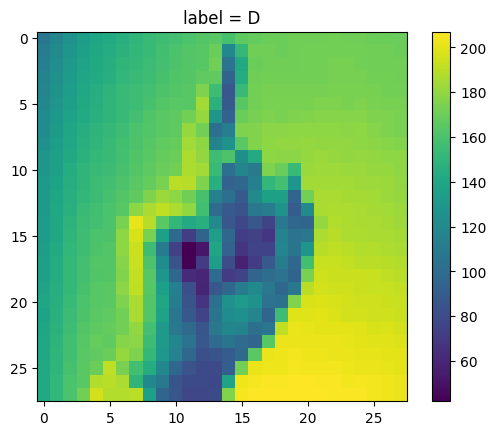

In [7]:
# Images are 28x28, so to view a row, reshape it into a 28x28 array
row_image = np.reshape(row_pixels, (28,28))
plt.imshow(row_image)
plt.title('label = ' + labels[row_label])
plt.colorbar()
plt.savefig('Image_'+'row_id'+'.png')
plt.show()

### Logistic Regression with PCA (2 components)

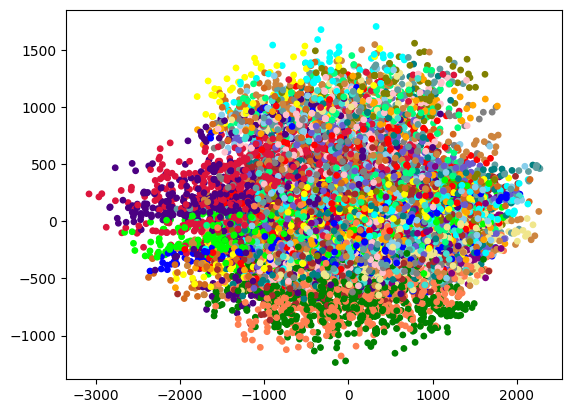

In [ ]:
pca = PCA(n_components=2)
transformed_data_2 = pca.fit_transform(train_data)
transformed_data_2 = transformed_data_2.T
color_map = np.array(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'lime', 'turquoise',
                       'teal', 'slateblue', 'coral', 'crimson', 'indigo', 'springgreen', 'cadetblue', 'khaki', 'yellow', 'skyblue', 'chocolate', 'peru', 'aqua'])
colors = color_map[train_data_labels]

plt.scatter(transformed_data_2[0], -transformed_data_2[1], c=colors, s=15)

In [38]:
log_reg = LogisticRegression(max_iter=1000)

fitted = log_reg.fit(train_data_no_label, train_data_labels)
predicted = log_reg.predict(test_data_no_label)

In [44]:
conf_matrix = confusion_matrix(test_data_labels, predicted)
conf_matrix_to_df(conf_matrix, labels)

,A,B,C,D,E,F,G,H,I,K,...,P,Q,R,S,T,U,V,W,X,Y
A,331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B,0,392,0,19,0,0,0,0,0,0,...,0,0,21,0,0,0,0,0,0,0
C,0,0,283,0,0,20,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
D,0,20,0,149,0,0,0,16,0,0,...,0,0,21,0,0,0,0,0,3,0
E,0,0,0,0,439,0,0,0,0,0,...,0,0,0,40,0,0,0,0,0,0
F,0,0,20,0,0,223,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,263,0,0,0,...,0,30,0,8,33,0,0,0,2,0
H,0,0,0,0,0,0,42,310,0,0,...,0,0,0,0,38,21,0,0,4,0
I,0,0,0,0,10,0,0,20,170,8,...,0,0,1,7,0,0,0,0,0,40
K,0,20,0,0,0,63,0,0,0,103,...,19,0,42,21,0,41,0,2,0,19


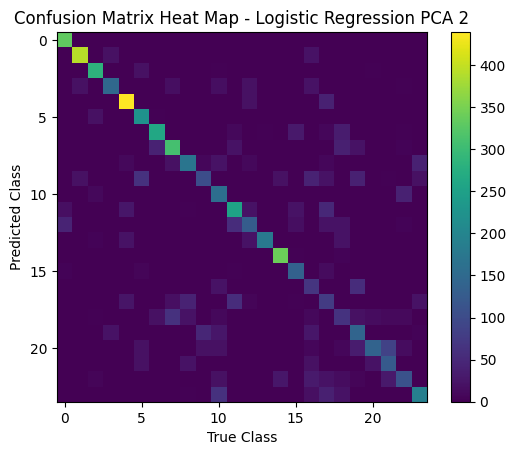

In [80]:
plt.title('Confusion Matrix Heat Map - Logistic Regression PCA 2')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.imshow(conf_matrix)
plt.colorbar()

In [47]:
print(classification_report(test_data_labels, predicted))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       331
           1       0.91      0.91      0.91       432
           2       0.87      0.91      0.89       310
           3       0.79      0.61      0.69       245
           4       0.84      0.88      0.86       498
           5       0.63      0.90      0.74       247
           6       0.80      0.76      0.78       348
           7       0.73      0.71      0.72       436
           8       0.65      0.59      0.62       288
          10       0.58      0.31      0.41       331
          11       0.44      0.76      0.56       209
          12       0.63      0.64      0.64       394
          13       0.57      0.44      0.50       291
          14       0.98      0.72      0.83       246
          15       0.88      0.98      0.93       347
          16       0.66      0.84      0.73       164
          17       0.25      0.47      0.33       144
          18       0.26    

### SVM

In [48]:
svc = SVC(kernel='linear')
svc_fit = svc.fit(train_data_no_label, train_data_labels)
svc_predict = svc.predict(test_data_no_label)

In [49]:
conf_matrix_svc = confusion_matrix(test_data_labels, svc_predict)
conf_matrix_to_df(conf_matrix_svc, labels)

,A,B,C,D,E,F,G,H,I,K,...,P,Q,R,S,T,U,V,W,X,Y
A,331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B,0,410,0,1,0,0,0,0,0,0,...,0,0,0,0,0,21,0,0,0,0
C,0,0,304,0,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,0,0,245,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,498,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F,0,0,21,0,0,206,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,299,16,0,0,...,0,14,0,0,19,0,0,0,0,0
H,1,0,0,0,9,0,20,382,0,0,...,0,0,0,0,0,18,0,0,0,0
I,0,0,0,0,0,0,0,0,214,17,...,0,0,21,0,1,0,0,0,0,35
K,0,0,0,15,0,24,0,0,8,131,...,0,0,41,16,0,42,0,37,0,17


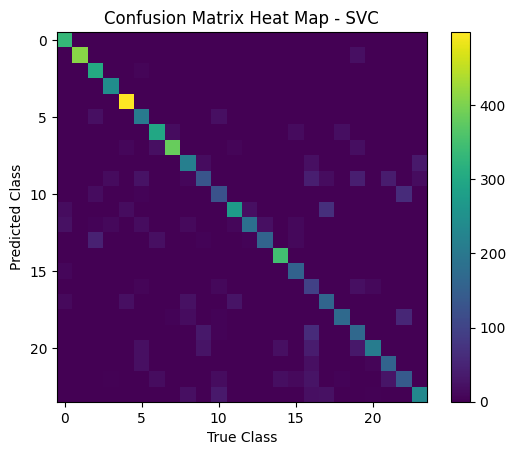

In [51]:
plt.title('Confusion Matrix Heat Map - SVC')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.imshow(conf_matrix_svc)
plt.colorbar()

In [53]:
print(classification_report(test_data_labels, svc_predict))

              precision    recall  f1-score   support

           0       0.84      1.00      0.92       331
           1       1.00      0.95      0.97       432
           2       0.78      0.98      0.87       310
           3       0.89      1.00      0.94       245
           4       0.92      1.00      0.96       498
           5       0.68      0.83      0.75       247
           6       0.84      0.86      0.85       348
           7       0.95      0.88      0.91       436
           8       0.73      0.74      0.74       288
          10       0.62      0.40      0.48       331
          11       0.58      0.60      0.59       209
          12       0.87      0.69      0.77       394
          13       0.88      0.63      0.74       291
          14       0.88      0.65      0.75       246
          15       0.90      1.00      0.95       347
          16       0.76      0.95      0.85       164
          17       0.30      0.67      0.41       144
          18       0.61    

Comparing Logistic Regression with PCA to SVM:

In [88]:
compare_metrics(conf_matrix, conf_matrix_svc)

Logistic Precision Average: 0.9106721859497787
SVM Precision Average: 0.9472401931150852
Logistic Recall Average: 0.8847757053729943
SVM Recall Average: 0.9424453855862602

SVM Precision on average is better
SVM Recall on average is better


### Random Forest

In [54]:
RFC = RandomForestClassifier()

fitted_rfc = RFC.fit(train_data_no_label, train_data_labels)
accuracy_rfc = RFC.score(test_data_no_label, test_data_labels)
print(accuracy_rfc)

0.8089793641940881


In [ ]:
forest_100 = [DecisionTreeClassifier(max_features='log2') for n in range(RFC.n_estimators)] # 100 trees total
for tree in forest_100:
  tree.fit(train_data_no_label, train_data_labels)
  tree.score(test_data_no_label, test_data_labels)

In [ ]:
ensemble_predictions = np.array([tree.predict(test_data_no_label) for tree in forest_100]).T

encoded_predictions = np.array([np.bincount(ensemble_predictions[i], minlength=10) for i in range(len(ensemble_predictions))], dtype=object)

predictions = [np.argmax(encoded_predictions[i]) for i in range(len(encoded_predictions))]

print("Accuracy for 100 trees:", np.sum(predictions == test_data_labels) / len(test_data_labels))

Accuracy: 0.8105131065253764


In [ ]:
# This takes about 5 mins on my machine, might take longer for others
forest_1000 = [DecisionTreeClassifier(max_features='log2') for n in range(1000)] # 1000 trees total
for tree in forest_1000:
  tree.fit(train_data_no_label, train_data_labels)
  tree.score(test_data_no_label, test_data_labels)

In [91]:
ensemble_predictions = np.array([tree.predict(test_data_no_label) for tree in forest_1000]).T

encoded_predictions = np.array([np.bincount(ensemble_predictions[i], minlength=10) for i in range(len(ensemble_predictions))], dtype=object)

predictions = [np.argmax(encoded_predictions[i]) for i in range(len(encoded_predictions))]

print("Accuracy for 1000 trees:", np.sum(predictions == test_data_labels) / len(test_data_labels))

Accuracy for 1000 trees: 0.8278025655326269


#### Below is the section of code I implemented for the check in that we did back in October

### CNN

Keras stuff - CSV

In [47]:
import tensorflow as tf
from tensorflow.keras import layers

In [48]:
model = tf.keras.Sequential([
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])

model.compile(loss = tf.keras.losses.MeanSquaredError(),
                      optimizer = tf.keras.optimizers.Adam())

In [49]:
model.fit(train_data, train_data_labels, epochs=100)

Epoch 1/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 2286.7146
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 116.6670
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 71.9666
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 66.5710
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 30.4517
Epoch 6/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 29.2084
Epoch 7/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 24.2972
Epoch 8/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 17.9504
Epoch 9/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 11.7914
Epoch 10/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 14.5245
Epoch 11/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 10.3487
Epoch 12/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 10.1512
Epoch 13/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 7.7523
Epoch 14/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 6.6523
Epoch 15/100
858/858 ━━━━━

In [50]:
prediction = model.predict(test_data)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [51]:
prediction

array([[5.92205  ],
       [4.865975 ],
       [9.681839 ],
       ...,
       [1.64892  ],
       [3.0762942],
       [1.8410218]], dtype=float32)

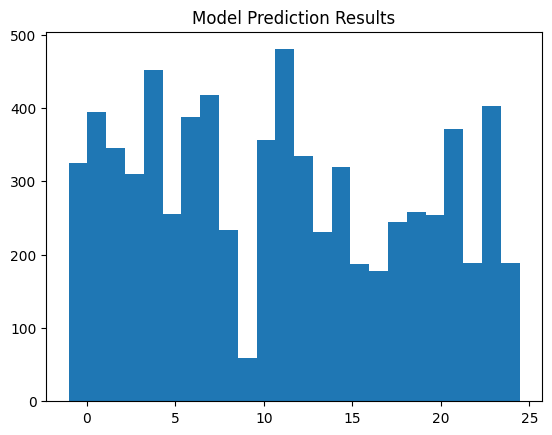

In [65]:
# This is a histogram of counts given to each label
plt.hist(prediction, bins=len(labels))
plt.title("Model Prediction Results")
plt.show()

In [53]:
# Rounds off the labels
prediction_rounded = np.array(prediction)

count = 0
for p in prediction_rounded:
    prediction_rounded[count] = np.round(p)
    count += 1

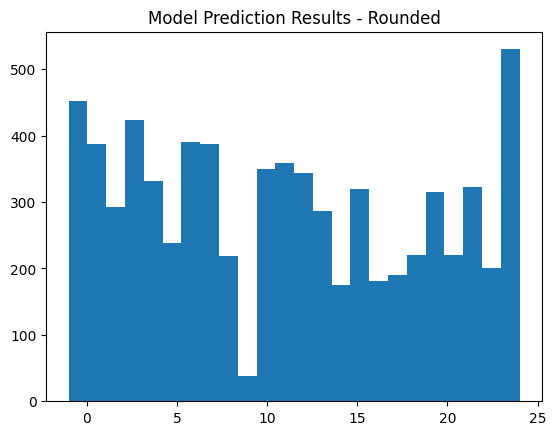

In [64]:
# This is a histogram of counts given to each label
plt.hist(prediction_rounded, bins=len(labels))
plt.title("Model Prediction Results - Rounded")
plt.show()

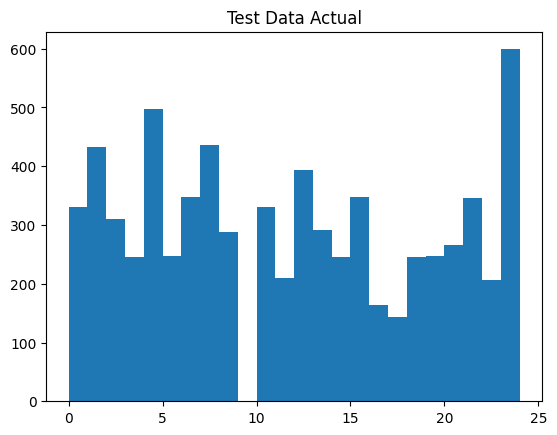

In [66]:
# This is a histogram of counts given to each label - ACTUAL TEST DATA
plt.hist(test_data_labels, bins=len(labels))
plt.title("Test Data Actual")
plt.show()

In [63]:
total_correct = 0

index = 0
for p in prediction_rounded:
    if p[index] == test_data_labels[index]:
        total_correct += 1

print("Total correct:", total_correct)
print("Total items:", len(test_data_labels))
print("Ratio correct:", total_correct/len(test_data_labels))

Total correct: 390
Total items: 7172
Ratio correct: 0.05437813720022309


Keras stuff - Images

In [56]:
#import tensorflow as tf

#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.models import Sequential

In [57]:
#len(train_data)

In [58]:
#batch_size = 32
#img_height = 28
#img_width = 28

#train_ds = tf.keras.utils.image_dataset_from_directory(
#  data_dir,
#  validation_split=0.2,
#  subset="training",
#  seed=123,
#  image_size=(img_height, img_width),
#  batch_size=batch_size)

In [59]:
#model = Sequential([
#  layers.Rescaling(1./255, input_shape=(28, 28, 3)),
#  layers.Conv2D(16, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(32, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(64, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Flatten(),
#  layers.Dense(128, activation='relu')
#])

In [60]:
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])

In [61]:
#model.summary()

In [62]:
#epochs=10
#history = model.fit(
#  train_data,
#  validation_data=test_data,
#  epochs=epochs
#)